In [27]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt
import optuna

C:\Users\jatin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading Data

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [5]:
class_names = dataset.classes
class_names 

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [8]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9602616].


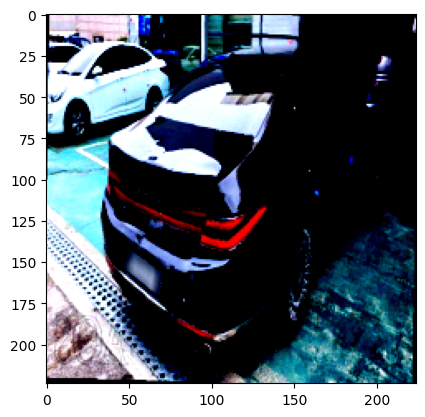

In [11]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

### Model 1: CNN

In [12]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [13]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [14]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.76
Batch: 20, Epoch: 1, Loss: 1.71
Batch: 30, Epoch: 1, Loss: 1.74
Batch: 40, Epoch: 1, Loss: 1.58
Batch: 50, Epoch: 1, Loss: 1.69
Epoch [1/10], Avg Loss: 1.7419
*** Validation Accuracy: 42.09% ***
Batch: 10, Epoch: 2, Loss: 1.68
Batch: 20, Epoch: 2, Loss: 1.37
Batch: 30, Epoch: 2, Loss: 1.19
Batch: 40, Epoch: 2, Loss: 1.37
Batch: 50, Epoch: 2, Loss: 1.05
Epoch [2/10], Avg Loss: 1.2825
*** Validation Accuracy: 51.48% ***
Batch: 10, Epoch: 3, Loss: 1.38
Batch: 20, Epoch: 3, Loss: 0.92
Batch: 30, Epoch: 3, Loss: 1.00
Batch: 40, Epoch: 3, Loss: 1.00
Batch: 50, Epoch: 3, Loss: 1.09
Epoch [3/10], Avg Loss: 1.0935
*** Validation Accuracy: 58.26% ***
Batch: 10, Epoch: 4, Loss: 0.92
Batch: 20, Epoch: 4, Loss: 0.73
Batch: 30, Epoch: 4, Loss: 1.08
Batch: 40, Epoch: 4, Loss: 1.04
Batch: 50, Epoch: 4, Loss: 0.95
Epoch [4/10], Avg Loss: 0.9937
*** Validation Accuracy: 58.96% ***
Batch: 10, Epoch: 5, Loss: 1.08
Batch: 20, Epoch: 5, Loss: 0.75
Batch: 30, Epoch: 5, Loss: 0

### Model 2: CNN with Regularization

In [16]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [17]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 14.67
Batch: 20, Epoch: 1, Loss: 6.64
Batch: 30, Epoch: 1, Loss: 2.69
Batch: 40, Epoch: 1, Loss: 1.57
Batch: 50, Epoch: 1, Loss: 1.46
Epoch [1/10], Avg Loss: 8.7600
*** Validation Accuracy: 39.65% ***
Batch: 10, Epoch: 2, Loss: 1.43
Batch: 20, Epoch: 2, Loss: 1.31
Batch: 30, Epoch: 2, Loss: 1.30
Batch: 40, Epoch: 2, Loss: 1.35
Batch: 50, Epoch: 2, Loss: 1.30
Epoch [2/10], Avg Loss: 1.3930
*** Validation Accuracy: 49.57% ***
Batch: 10, Epoch: 3, Loss: 1.20
Batch: 20, Epoch: 3, Loss: 1.27
Batch: 30, Epoch: 3, Loss: 1.42
Batch: 40, Epoch: 3, Loss: 1.46
Batch: 50, Epoch: 3, Loss: 1.06
Epoch [3/10], Avg Loss: 1.2802
*** Validation Accuracy: 52.52% ***
Batch: 10, Epoch: 4, Loss: 1.50
Batch: 20, Epoch: 4, Loss: 1.11
Batch: 30, Epoch: 4, Loss: 1.29
Batch: 40, Epoch: 4, Loss: 1.28
Batch: 50, Epoch: 4, Loss: 0.83
Epoch [4/10], Avg Loss: 1.2285
*** Validation Accuracy: 52.70% ***
Batch: 10, Epoch: 5, Loss: 1.08
Batch: 20, Epoch: 5, Loss: 1.02
Batch: 30, Epoch: 5, Loss: 

### Model 3: Transfer Learning via EfficientNet

In [18]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\jatin/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████| 20.5M/20.5M [00:04<00:00, 5.30MB/s]


1280

In [19]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x   

In [20]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.65
Batch: 20, Epoch: 1, Loss: 1.29
Batch: 30, Epoch: 1, Loss: 1.41
Batch: 40, Epoch: 1, Loss: 1.34
Batch: 50, Epoch: 1, Loss: 1.25
Epoch [1/10], Avg Loss: 1.4856
*** Validation Accuracy: 61.22% ***
Batch: 10, Epoch: 2, Loss: 1.19
Batch: 20, Epoch: 2, Loss: 1.07
Batch: 30, Epoch: 2, Loss: 1.12
Batch: 40, Epoch: 2, Loss: 0.93
Batch: 50, Epoch: 2, Loss: 1.16
Epoch [2/10], Avg Loss: 1.1510
*** Validation Accuracy: 65.74% ***
Batch: 10, Epoch: 3, Loss: 1.40
Batch: 20, Epoch: 3, Loss: 0.97
Batch: 30, Epoch: 3, Loss: 1.16
Batch: 40, Epoch: 3, Loss: 1.05
Batch: 50, Epoch: 3, Loss: 0.98
Epoch [3/10], Avg Loss: 1.0312
*** Validation Accuracy: 68.00% ***
Batch: 10, Epoch: 4, Loss: 0.90
Batch: 20, Epoch: 4, Loss: 0.99
Batch: 30, Epoch: 4, Loss: 0.79
Batch: 40, Epoch: 4, Loss: 0.81
Batch: 50, Epoch: 4, Loss: 0.81
Epoch [4/10], Avg Loss: 0.9499
*** Validation Accuracy: 68.52% ***
Batch: 10, Epoch: 5, Loss: 0.95
Batch: 20, Epoch: 5, Loss: 0.91
Batch: 30, Epoch: 5, Loss: 0

### Transfer Learning via ResNet

In [21]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [22]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\jatin/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|█████████████████████████████████████| 97.8M/97.8M [00:25<00:00, 4.10MB/s]


Batch: 10, Epoch: 1, Loss: 0.92
Batch: 20, Epoch: 1, Loss: 0.77
Batch: 30, Epoch: 1, Loss: 0.87
Batch: 40, Epoch: 1, Loss: 0.56
Batch: 50, Epoch: 1, Loss: 0.51
Epoch [1/10], Avg Loss: 0.8809
*** Validation Accuracy: 77.74% ***
Batch: 10, Epoch: 2, Loss: 0.76
Batch: 20, Epoch: 2, Loss: 0.36
Batch: 30, Epoch: 2, Loss: 0.39
Batch: 40, Epoch: 2, Loss: 0.44
Batch: 50, Epoch: 2, Loss: 0.50
Epoch [2/10], Avg Loss: 0.4915
*** Validation Accuracy: 78.09% ***
Batch: 10, Epoch: 3, Loss: 0.23
Batch: 20, Epoch: 3, Loss: 0.42
Batch: 30, Epoch: 3, Loss: 0.59
Batch: 40, Epoch: 3, Loss: 0.43
Batch: 50, Epoch: 3, Loss: 0.27
Epoch [3/10], Avg Loss: 0.3532
*** Validation Accuracy: 75.13% ***
Batch: 10, Epoch: 4, Loss: 0.05
Batch: 20, Epoch: 4, Loss: 0.24
Batch: 30, Epoch: 4, Loss: 0.32
Batch: 40, Epoch: 4, Loss: 0.37
Batch: 50, Epoch: 4, Loss: 0.18
Epoch [4/10], Avg Loss: 0.2622
*** Validation Accuracy: 82.78% ***
Batch: 10, Epoch: 5, Loss: 0.10
Batch: 20, Epoch: 5, Loss: 0.09
Batch: 30, Epoch: 5, Loss: 0

### Hyperparameter Tuning

In [25]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    
    # Load the model
    model = CarClassifierResNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    # Training loop (using fewer epochs for faster hyperparameter tuning)
    epochs = 3
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        
        # Report intermediate result to Optuna
        trial.report(accuracy, epoch)
        
        # Handle pruning (if applicable)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print(f"Execution time: {end - start} seconds")
    
    return accuracy

In [28]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-08-05 20:42:44,621] A new study created in memory with name: no-name-b75b32da-be6f-4668-ad5c-f2e319ac0edc
[I 2025-08-05 20:47:31,081] Trial 0 finished with value: 79.65217391304348 and parameters: {'lr': 8.832822237481398e-05, 'dropout_rate': 0.29016412391539304}. Best is trial 0 with value: 79.65217391304348.


Execution time: 285.79025173187256 seconds


[I 2025-08-05 20:52:27,251] Trial 1 finished with value: 58.95652173913044 and parameters: {'lr': 1.7607608934087154e-05, 'dropout_rate': 0.27043691213806803}. Best is trial 0 with value: 79.65217391304348.


Execution time: 295.5828261375427 seconds


[I 2025-08-05 20:56:56,400] Trial 2 finished with value: 80.69565217391305 and parameters: {'lr': 0.0007656994450664724, 'dropout_rate': 0.6327065528097575}. Best is trial 2 with value: 80.69565217391305.


Execution time: 268.64139103889465 seconds


[I 2025-08-05 21:02:17,957] Trial 3 finished with value: 76.0 and parameters: {'lr': 0.00016695407931263616, 'dropout_rate': 0.5790072849661132}. Best is trial 2 with value: 80.69565217391305.


Execution time: 321.10636806488037 seconds


[I 2025-08-05 21:06:48,744] Trial 4 finished with value: 81.21739130434783 and parameters: {'lr': 0.0037988120760543646, 'dropout_rate': 0.32283335427632326}. Best is trial 4 with value: 81.21739130434783.


Execution time: 270.2751564979553 seconds


[I 2025-08-05 21:09:49,134] Trial 5 pruned. 
[I 2025-08-05 21:11:19,253] Trial 6 pruned. 
[I 2025-08-05 21:15:44,743] Trial 7 pruned. 
[I 2025-08-05 21:17:14,760] Trial 8 pruned. 
[I 2025-08-05 21:22:40,588] Trial 9 finished with value: 80.52173913043478 and parameters: {'lr': 0.00035038471781000325, 'dropout_rate': 0.4028782578498845}. Best is trial 4 with value: 81.21739130434783.


Execution time: 325.24021768569946 seconds


[I 2025-08-05 21:24:42,452] Trial 10 pruned. 
[I 2025-08-05 21:29:23,600] Trial 11 pruned. 
[I 2025-08-05 21:33:57,777] Trial 12 pruned. 
[I 2025-08-05 21:37:23,723] Trial 13 pruned. 
[I 2025-08-05 21:42:57,884] Trial 14 pruned. 
[I 2025-08-05 21:44:40,781] Trial 15 pruned. 
[I 2025-08-05 21:50:36,345] Trial 16 pruned. 
[I 2025-08-05 21:52:07,336] Trial 17 pruned. 
[I 2025-08-05 21:53:44,705] Trial 18 pruned. 
[I 2025-08-05 21:58:37,636] Trial 19 pruned. 


In [29]:
study.best_params

{'lr': 0.0037988120760543646, 'dropout_rate': 0.32283335427632326}

In [30]:
#Retraining the model with the optimized hyperparameters
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.003)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 0.98
Batch: 20, Epoch: 1, Loss: 0.65
Batch: 30, Epoch: 1, Loss: 0.64
Batch: 40, Epoch: 1, Loss: 0.58
Batch: 50, Epoch: 1, Loss: 1.07
Epoch [1/10], Avg Loss: 0.9074
*** Validation Accuracy: 58.78% ***
Batch: 10, Epoch: 2, Loss: 0.55
Batch: 20, Epoch: 2, Loss: 0.62
Batch: 30, Epoch: 2, Loss: 0.45
Batch: 40, Epoch: 2, Loss: 0.60
Batch: 50, Epoch: 2, Loss: 0.59
Epoch [2/10], Avg Loss: 0.5291
*** Validation Accuracy: 80.17% ***
Batch: 10, Epoch: 3, Loss: 0.39
Batch: 20, Epoch: 3, Loss: 0.46
Batch: 30, Epoch: 3, Loss: 0.32
Batch: 40, Epoch: 3, Loss: 0.54
Batch: 50, Epoch: 3, Loss: 0.47
Epoch [3/10], Avg Loss: 0.4038
*** Validation Accuracy: 80.00% ***
Batch: 10, Epoch: 4, Loss: 0.13
Batch: 20, Epoch: 4, Loss: 0.20
Batch: 30, Epoch: 4, Loss: 0.26
Batch: 40, Epoch: 4, Loss: 0.43
Batch: 50, Epoch: 4, Loss: 0.28
Epoch [4/10], Avg Loss: 0.2816
*** Validation Accuracy: 70.96% ***
Batch: 10, Epoch: 5, Loss: 0.32
Batch: 20, Epoch: 5, Loss: 0.38
Batch: 30, Epoch: 5, Loss: 0

In [31]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       121
           1       0.77      0.77      0.77        97
           2       0.91      0.89      0.90       124
           3       0.72      0.76      0.74        70
           4       0.64      0.59      0.61        70
           5       0.85      0.83      0.84        93

    accuracy                           0.81       575
   macro avg       0.79      0.79      0.79       575
weighted avg       0.81      0.81      0.81       575



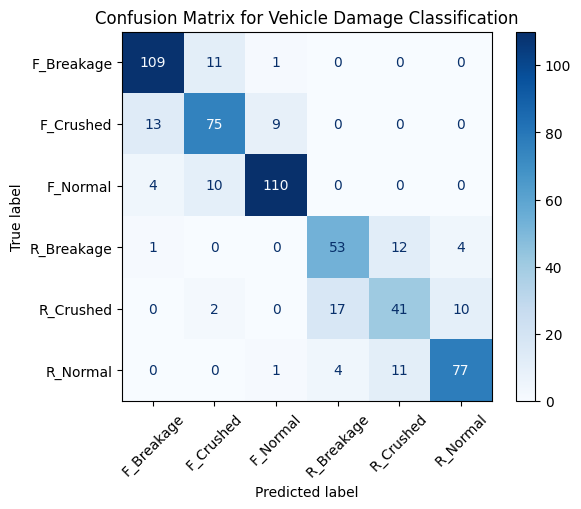

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Saving the Best performing Model

In [35]:
torch.save(model.state_dict(), 'saved_model.pth')